# Face Recognition
This notebook aims to conceive a ML model that is able to recognize and idenfity faces in near real time.

The compared models include:
* Linear Regression
* Logistic Regression
* Support Vector Machines
* Neural Networks
* Hidden Markov Models

For feature extraction we use Singular Value Decomposition

The paper for this notebook can be found at: URL

## Introduction
Face recognition has proven to be of more and more use as technology advances. Real-time identification of people, further security when unlocking personal devices or even implementing a social credit point system like in China :) Unlike face detection, which focuses on understanding where a face is on a given picture, face recognition focuses on understanding who the face in a picture belongs to; in other words, identifying people.


## Loading libraries

In [1]:
# Helper libraries
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt
import re
import glob
import os

from scipy.io import loadmat

# TensorFlow and Keras
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical

## Loading the data
The dataset used for this project was the [ORL Face database](http://cam-orl.co.uk/facedatabase.html "Show me the data"). There
are 40 people in this dataset and each person has 10 images. These images have a size of 112 × 92. 112 is the height of the image and 92 is the width of the image. Each image contains only one face. 

Let us start by loading and sampling the data.

In [2]:
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [3]:
# Load filenames into a list
files = [ 
       os.path.join(parent, name)
       for (parent, subdirs, files) in os.walk("data")
       for name in files + subdirs if name[-3:] == "pgm"
   ]


data = []

# Load images into a labelled matrix
for f in files:
    image = read_pgm(f)
    new_img = image.reshape((image.shape[0] * image.shape[1], 1))
    
    # Normalizing the data
    new_img = new_img / 255
    
    label = int(f.split("/")[-2][1:])

    new_img = np.append(new_img, label)

    data += [new_img]
    
    
np_data = np.array(data)

X_full = np_data.reshape(np_data.shape[0], np_data.shape[1])
X = X_full[:, :-1]
y = X_full[:, -1].reshape((X.shape[0], 1))
np.random.shuffle(X_full)

In [4]:
print(X_full.shape)
print(X.shape)
print(y.shape)

(410, 10305)
(410, 10304)
(410, 1)


### Classes
Additionally, let's also load the class numbers as well as a useful macro: the image dimensions (DIMS). Since we have 41 subjects, class names will merely be their indexes

In [5]:
classes = range(0, 41)
DIMS = (112, 92)

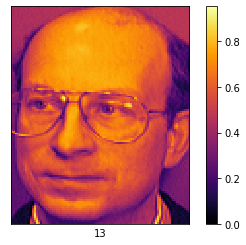

In [6]:
# Display one full image
def show_image(row):
    image = row[:-1].reshape(DIMS)

    plt.subplot(1, 1, 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image, plt.cm.inferno)
    plt.xlabel(classes[int(row[-1])])
    plt.colorbar()
    
row = X_full[59]
show_image(row)

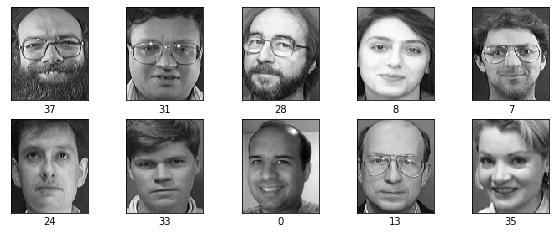

In [7]:
# Display sample_size images (with 1 < sample_size < 40)
sample_size = 10
plt.figure(figsize=(10,10))

for i in range(0, sample_size):
    idx = np.random.randint(0, 410)
    image = X[idx].reshape(DIMS)
    plt.subplot(5,5,i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(image, plt.cm.gray)
    plt.xlabel(classes[int(y[idx])])
    
plt.show()

In [9]:
# Data shape and format
df = pd.DataFrame(X_full)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,10304
0,0.392157,0.411765,0.403922,0.411765,0.423529,0.396078,0.415686,0.403922,0.419608,0.411765,...,0.192157,0.168627,0.164706,0.164706,0.149020,0.160784,0.160784,0.145098,0.145098,12.0
1,0.462745,0.447059,0.458824,0.450980,0.458824,0.458824,0.454902,0.466667,0.447059,0.454902,...,0.215686,0.203922,0.180392,0.207843,0.219608,0.188235,0.227451,0.211765,0.203922,4.0
2,0.431373,0.415686,0.415686,0.411765,0.423529,0.431373,0.411765,0.419608,0.431373,0.427451,...,0.078431,0.066667,0.094118,0.074510,0.078431,0.070588,0.074510,0.082353,0.074510,13.0
3,0.427451,0.411765,0.439216,0.419608,0.431373,0.427451,0.427451,0.427451,0.439216,0.435294,...,0.274510,0.243137,0.258824,0.270588,0.149020,0.184314,0.215686,0.196078,0.200000,26.0
4,0.180392,0.188235,0.160784,0.184314,0.180392,0.172549,0.203922,0.176471,0.188235,0.203922,...,0.164706,0.149020,0.168627,0.160784,0.160784,0.152941,0.137255,0.141176,0.145098,36.0


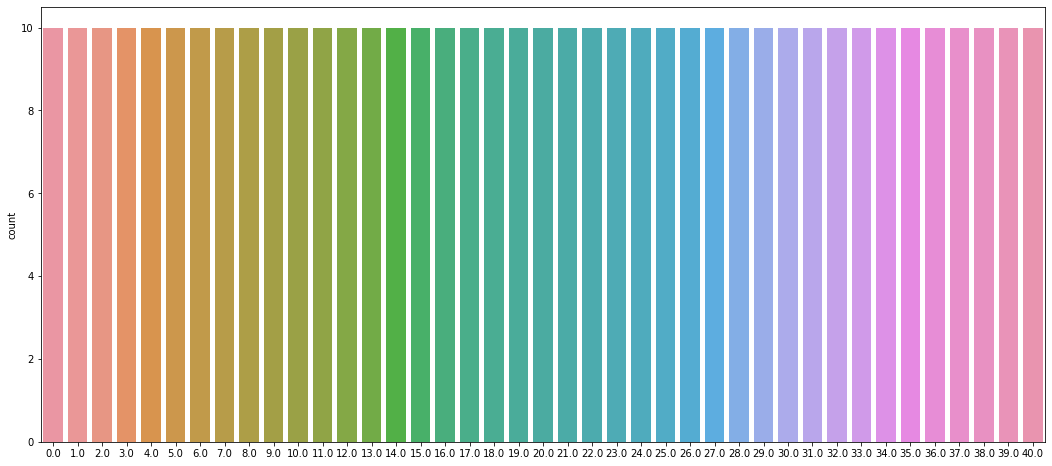

In [8]:
# Image count
plt.figure(figsize = (18,8))
sns.countplot(x = y[:, 0])
plt.show()

## Processing and analyzing the data

-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


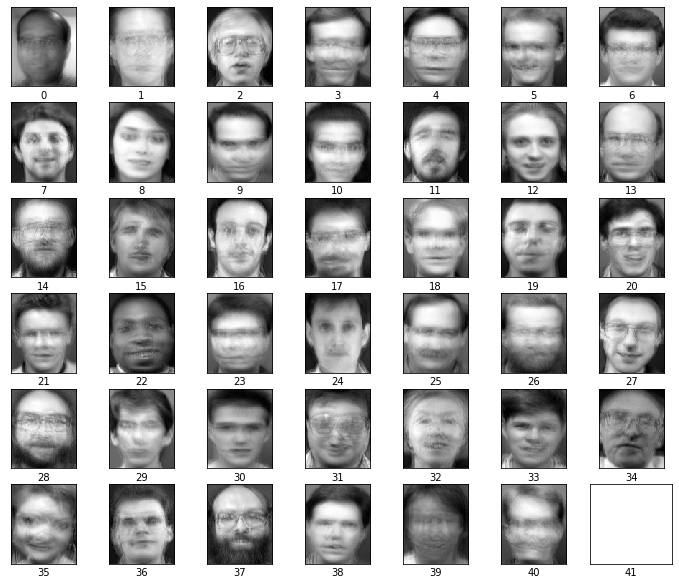

In [182]:
# Plot mean image for each class

arr=np.zeros((10304,),np.float)

meanAA = [arr] * 41

plt.figure(figsize=(12,12))

for i in range(0, 410):
    image = X[i]
    meanAA[classes[int(y[i])]] = meanAA[classes[int(y[i])]] + image
    
for i in range(0, 42):
    plt.imshow((meanAA[i-1] / 10).reshape(DIMS), plt.cm.gray)
        
    plt.subplot(7,7,i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.xlabel(i)
    
plt.show()

In [170]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(len(imageA))
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [171]:
mse(meanAA[0], meanAA[1])

6.527537976614346

41


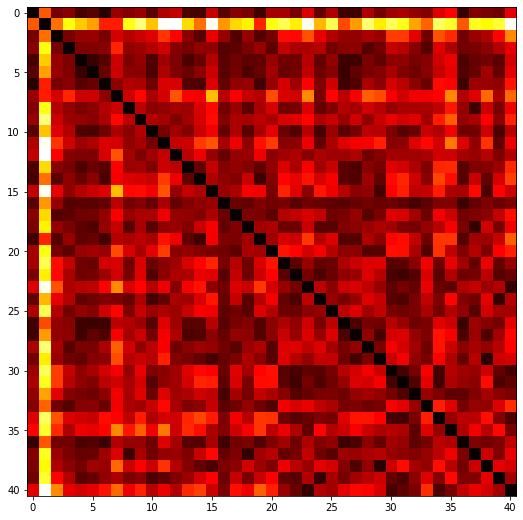

In [181]:
pre_confusion = np.zeros((41, 41))
print(len(meanAA))

for k in range(0, 41):
    for j in range(0, 41):
        pre_confusion[k, j] = mse(meanAA[j-1], meanAA[k-1])
        

plt.imshow(pre_confusion, cmap='hot', interpolation='nearest')
plt.show()

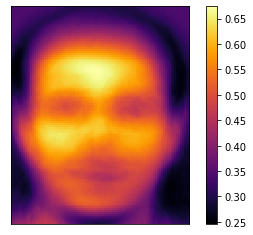

In [10]:
# Plotting the mean image
# TODO: Plot the mean image for each class, Confusion Matrix Ordering to notice similar classes
# and Eigenfaces
mean_img = np.array([])

for idx in range(df.shape[1] - 1):
    mean_img = np.append(mean_img, [df[idx].mean()], axis=0)
    
mean_img.reshape((mean_img.shape[0], 1))

image = mean_img.reshape(DIMS)

plt.subplot(1, 1, 1)
plt.xticks([])
plt.yticks([])
plt.grid(True)
plt.imshow(image, plt.cm.inferno)
plt.colorbar()
plt.show()

# Splitting the Data into Train, Valid and Test sets

Now that we are going to try out different machine learning models, we need a validation set in order to benchmark how well different models perform against each other. That being said we will split our data into train (60%), validation (20%) and test (20%) sets.

In [11]:
# 60 20 20
ratio = [0.6, 0.2, 0.2]

train_idx = int(ratio[0] * X_full.shape[0])
valid_idx = int(train_idx + ratio[1] * X_full.shape[0])

X_train = X_full[:train_idx][:]
X_valid = X_full[train_idx:valid_idx][:]
X_test = X_full[valid_idx:][:]

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)


(246, 10305)
(82, 10305)
(82, 10305)


# Model 1: Multivariate Linear Regression
For a first approach, let us implement and test a LinReg model with a Gradient Descent optimizer.

In [12]:
def computeCost(X,y,theta):
    """
   Take the numpy arrays X, y, theta and return the cost function J for this theta. 

    """
    m=len(y)
    h= np.dot(X, theta)
    J= 1/(2*m) * np.sum(np.power((h - y),2))

    return J

In [13]:
def gradient_descent(X,y,theta,alpha,num_iters):
    """
    Take numpy arrays X, y and theta and update theta by taking num_iters gradient steps with learning rate alpha
    
     Return: theta and the list of the cost of theta (J_history) during each iteration
    """
    
    m=len(y)
    J_history=[]
    
    for i in range(num_iters):
        h = np.dot(X,theta)
        grad = np.dot(X.transpose(),(h-y)) #Vectorized way to compute all gradients simultaneously -> partial derivatives
        theta= theta - ( alpha * 1/m * grad )
        
        J_history.append(computeCost(X,y,theta))
    
    return theta, J_history

In [72]:
lin_theta = np.zeros((X_train.shape[1],1))

train_examples = X_train[:,:-1]
train_labels = X_train[:, -1]
train_labels = train_labels.reshape((train_labels.shape[0], 1))

#theta, J_history = gradient_descent(train_examples, train_labels,theta, 0.0001, 100000) # 0.07317 acc
lin_theta1, lin_J_history1 = gradient_descent(np.append(train_examples, np.ones((X_train.shape[0], 1)), axis=1), train_labels,np.zeros((X_train.shape[1],1)), 0.0001, 150)
lin_theta2, lin_J_history2 = gradient_descent(np.append(train_examples, np.ones((X_train.shape[0], 1)), axis=1), train_labels,np.zeros((X_train.shape[1],1)), 0.0003, 150)
lin_theta3, lin_J_history3 = gradient_descent(np.append(train_examples, np.ones((X_train.shape[0], 1)), axis=1), train_labels,np.zeros((X_train.shape[1],1)), 0.0005, 150)
lin_theta4, lin_J_history4 = gradient_descent(np.append(train_examples, np.ones((X_train.shape[0], 1)), axis=1), train_labels,np.zeros((X_train.shape[1],1)), 0.0008, 150)

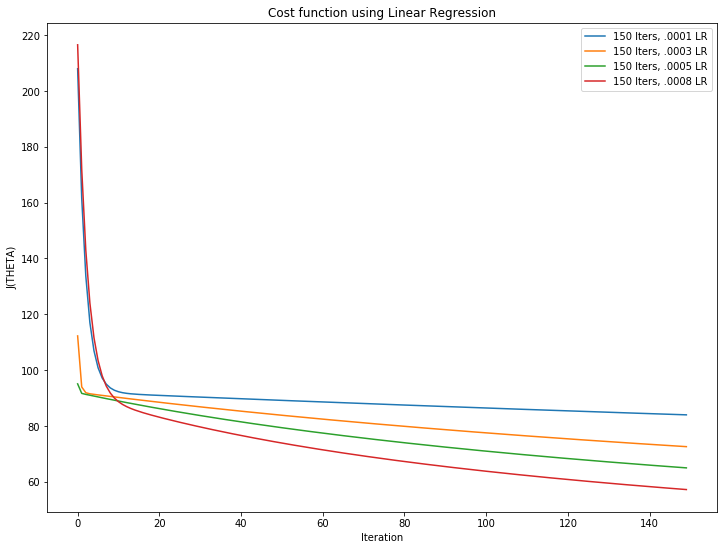

In [73]:
plt.plot(lin_J_history1)
plt.plot(lin_J_history2)
plt.plot(lin_J_history3)
plt.plot(lin_J_history4)

plt.legend(["150 Iters, .0001 LR",
            "150 Iters, .0003 LR", 
            "150 Iters, .0005 LR",
            "150 Iters, .0008 LR"])

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

plt.title("Cost function using Linear Regression")
plt.xlabel("Iteration")
plt.ylabel("J(THETA)")
plt.show()

In [16]:
def predict(X,theta):
    """
    Takes in numpy array of x and theta and return the predicted value of y based on theta
    """
    
    h= np.dot(X, theta)
    
    return h[0]

In [17]:
# Validate and fetch an accuracy for this model
def validate_linear(valid_set, theta):
    hits = 0

    for v in valid_set:
        vec = np.append(v[:-1], np.ones((1, 1)))
        predicted = predict(vec, theta)
        if int(predicted) == int(v[-1]):
            hits += 1

    return hits, hits / valid_set.shape[0]

In [56]:
print("Number of hits and Accuracy: ", validate_linear(X_valid, lin_theta1))
print("Number of hits and Accuracy: ", validate_linear(X_valid, lin_theta2))
print("Number of hits and Accuracy: ", validate_linear(X_valid, lin_theta3))
print("Number of hits and Accuracy: ", validate_linear(X_valid, lin_theta4))

Number of hits and Accuracy:  (0, 0.0)
Number of hits and Accuracy:  (1, 0.012195121951219513)
Number of hits and Accuracy:  (2, 0.024390243902439025)
Number of hits and Accuracy:  (1, 0.012195121951219513)


This performs very poorly, but it is always worth a shot. Let us now try out a Logsitic Regression Model.

# Model 2: Logistic Regression
For a second attempt, let's try to implement a Logistic function and classify different images instead of predicting a real number. Since this is a multiclass classification problem, we will need One Vs All strategy, in order to train one label against all others at a time, resulting in K * n_iterations per model.

## Implementing Logistic Regression by hand

In [19]:
def sigmoid(z):
    """
    return the sigmoid of z
    """
    
    gz= 1 / (1 + np.exp(-z))
    
    return gz

In [20]:
def cost_function_reg(X, y, theta, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    #number of training examples 
    m = X.shape[0]
            
    #vector of the model predictions for all training examples      
    h = sigmoid(np.dot(X, theta))
    
    
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))
    
    #cost function without regularization term
    cost = sum(error)/m
    
    #add regularization term to the cost function
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    #gradient of theta_0
    grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    #vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all=np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

In [21]:
def gradient_descent_reg(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history = []
    
    for i in range(num_iters):
        
        cost, grad = cost_function_reg(X, y, theta, Lambda)
        
        #update theta
        theta = theta - (alpha * grad)
        
        J_history.append(cost)
    
    return theta , J_history

In [22]:
def one_vs_all(X, y, initial_theta, alpha, num_iters, Lambda, K):
    """
    Inputs:
    numpy array of data X and labels y
    initial_theta - inicialized vector of model parameters theta 
    alpha - learning rate
    num_iters - number of iterations
    Lambda - regularization parameter 
    K -number of classes
    
    ONEVSALL trains K Logistic Regression classifiers using gradient descent. 
    
    Returns:   
    all_theta - Kxn matrix where i-th row corresponds to the i-th classifier, n parameters
    all_J - the evolution of cost function during each iteration (J_history) for all K classifiers
    
    """
    all_theta = []
    all_J=[]
    
    #number of training examples
    m=X.shape[0]
    
    #number of features
    n=X.shape[1]
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((m, 1)), X, axis=1)
    
    for i in range(1,K+1):
        theta , J_history = gradient_descent_reg(X,np.where(y==i,1,0),initial_theta,alpha,num_iters, Lambda)
        
        #update (extend)
        all_theta.extend(theta)
        
        #update (extend)
        all_J.extend(J_history)
        
    return np.array(all_theta).reshape(K,n+1), all_J

In [23]:
# Inicialize vector theta = 0
initial_theta = np.zeros((X_full.shape[1], 1))

In [24]:
log_theta1, log_J_history1 = one_vs_all(train_examples, train_labels, initial_theta, 0.0001, 100, 0.1, 41)
log_theta2, log_J_history2 = one_vs_all(train_examples, train_labels, initial_theta, 0.001, 80, 0.1, 41)
log_theta3, log_J_history3 = one_vs_all(train_examples, train_labels, initial_theta, 0.0005, 100, 0.1, 41)
log_theta4, log_J_history4 = one_vs_all(train_examples, train_labels, initial_theta, 0.0001, 120, 0.2, 41)

print("The cost for the optimized theta1:",round(log_J_history1[-1],3))
print("The cost for the optimized theta2:",round(log_J_history2[-1],3))
print("The cost for the optimized theta3:",round(log_J_history3[-1],3))
print("The cost for the optimized theta4:",round(log_J_history4[-1],3))

The cost for the optimized theta1: 0.052
The cost for the optimized theta2: 0.025
The cost for the optimized theta3: 0.011
The cost for the optimized theta4: 0.026


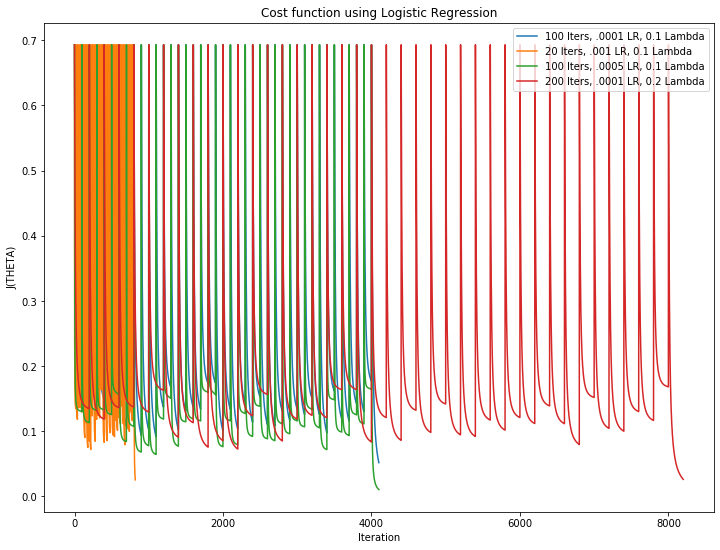

In [47]:
plt.plot(log_J_history1)
plt.plot(log_J_history2)
plt.plot(log_J_history3)
plt.plot(log_J_history4)

plt.legend(["100 Iters, .0001 LR, 0.1 Lambda",
            "80 Iters, .001 LR, 0.1 Lambda",
            "100 Iters, .0005 LR, 0.1 Lambda",
            "120 Iters, .0001 LR, 0.2 Lambda"])

plt.title("Cost function using Logistic Regression")
plt.xlabel("Iteration")
plt.ylabel("J(THETA)")

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

plt.show()

In [26]:
# Validate and fetch an accuracy for this model by making predictionsX_valid[:, :-1]X_valid[:, :-1]
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of image X(i) for each class and predict the label
    
    return a vector of prediction
    """
    #number of training examples
    m=X.shape[0]
    
    # add an extra column of 1´s corresponding to xo=1 (aka intercept term)
    X = np.append(np.ones((m, 1)), X, axis=1)
    
    predictions = np.dot (X, all_theta.T) # predictions.shape =(5000,10)
    #np.argmax returns indices of the max element of the array in a particular axis.
    #+1 in order to label 0 as 10. 
    return np.argmax(predictions,axis=1)+1

In [27]:
pred = predictOneVsAll(log_theta3, train_examples)

pred= pred.reshape((pred.shape[0], 1))

print("Training Set Accuracy:",sum(pred==train_labels)[0]/X_train.shape[0]*100,"%")

Training Set Accuracy: 17.073170731707318 %


In [28]:
pred = predictOneVsAll(log_theta3, X_valid[:, :-1])

pred= pred.reshape((pred.shape[0], 1))

print("Validation Set Accuracy:",sum(pred==X_valid[:, -1])[0]/X_valid.shape[0]*100,"%")

Validation Set Accuracy: 0.0 %


## Logistic Regression using scikit-learn

In [29]:
from sklearn.linear_model import LogisticRegression

# all parameters not specified are set to their defaults
logisticRegr1 = LogisticRegression(C=1.0)

logisticRegr1.fit(train_examples, np.ravel(train_labels))

/home/melo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/melo/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
print("Model 1 predicting the class of the first element: ", logisticRegr1.predict(X_valid[0, :-1].reshape(1,-1)), "\nCorrect first element: ", X_valid[:, -1][0])

Model 1 predicting the class of the first element:  [29.] 
Correct first element:  29.0


In [31]:
predictions1 = logisticRegr1.predict(X_valid[:, :-1])
score1 = logisticRegr1.score(X_valid[:, :-1], X_valid[:, -1])

print("Validation Accuracy for Model 1: ", score1)

Validation Accuracy for Model 1:  0.9634146341463414


# Model 3: Support Vector Machine (SVM)

In [32]:
from sklearn.svm import SVC

# Instancing and training
classifier = SVC(C=1, kernel="linear")

classifier.fit(train_examples,np.ravel(train_labels))

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [33]:
# Making predictions
print("Model 1 predicting the class of the first element: ", classifier.predict(X_valid[:, :-1])[0], "\nCorrect first element: ", X_valid[:, -1][0])

print("\nValidation Accuracy for Model 1: ", classifier.score(X_valid[:, :-1], X_valid[:, -1]))

Model 1 predicting the class of the first element:  29.0 
Correct first element:  29.0

Validation Accuracy for Model 1:  0.9878048780487805


# Model 4: Neural Networks

## Implementing Neural Networks by hand

In [34]:
#Computes the gradient of sigmoid function
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid) 

In [35]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [36]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X)) # np.append.. axis=1
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T) # @ = np.dot()
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # backpropagation algorithm to compute the gradients
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] 
        a1i = a1[i,:] 
        a2i =a2[i,:] 
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg

In [37]:
def gradient_descent_nn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [66]:
input_layer_size  = 10304
hidden_layer_size = 30

num_labels = 41

initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

nnTheta1, nnJ_history1 = gradient_descent_nn(train_examples, train_labels, initial_nn_params,0.1,100,0.1,input_layer_size, 30, num_labels)
nnTheta2, nnJ_history2 = gradient_descent_nn(train_examples, train_labels, initial_nn_params,0.2,80,0.1,input_layer_size, hidden_layer_size, num_labels)
nnTheta3, nnJ_history3 = gradient_descent_nn(train_examples, train_labels, initial_nn_params,0.01,120,0.1,input_layer_size, hidden_layer_size, num_labels)

Theta11 = nnTheta1[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta21 = nnTheta1[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

Theta12 = nnTheta3[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta22 = nnTheta3[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

Theta13 = nnTheta3[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta23 = nnTheta3[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

In [59]:
def predict_nn(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
    
    #number of training examples
    m= X.shape[0]
        
    # add an extra column of 1´s corresponding to xo=1
    X = np.append(np.ones((m, 1)), X, axis=1)
    
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1= np.dot(X, Theta1.T)  #Inputs to the hidden layer neurons
    a1= sigmoid(z1)  #Outputs  of the hidden layer neurons
    
    #Add a column of ones
    a1 = np.append(np.ones((a1.shape[0], 1)), a1, axis=1)
    
    #Compute the output of the output layer (with sigmoid activation functions)
    z2= np.dot(a1, Theta2.T)  #Inputs to the output layer neurons
    a2= sigmoid(z2)  #Outputs  of the output layer neurons
    
    return np.argmax(a2,axis=1)+1

In [40]:
pred_train_nn1 = predict_nn(Theta11, Theta21, train_examples)
pred_train_nn2 = predict_nn(Theta12, Theta22, train_examples)
pred_train_nn3 = predict_nn(Theta13, Theta23, train_examples)

print("Training Set Accuracy for Model 1:",sum(pred_train_nn1==train_labels)[0]/X_train.shape[0]*100,"%")
print("Training Set Accuracy for Model 2:",sum(pred_train_nn2==train_labels)[0]/X_train.shape[0]*100,"%")
print("Training Set Accuracy for Model 3:",sum(pred_train_nn3==train_labels)[0]/X_train.shape[0]*100,"%")

Training Set Accuracy for Model 1: 3.6585365853658534 %
Training Set Accuracy for Model 2: 3.6585365853658534 %
Training Set Accuracy for Model 3: 3.6585365853658534 %


In [58]:
# Validate using the best performing model
pred_valid_nn = predict_nn(Theta1, Theta2, X_valid[:, :-1])
print("Validation Set Accuracy:",sum(pred_valid_nn==X_valid[:, -1])/X_valid.shape[0]*100,"%")

NameError: name 'Theta1' is not defined

Text(0.5, 1.0, 'Cost function using Gradient Descent')

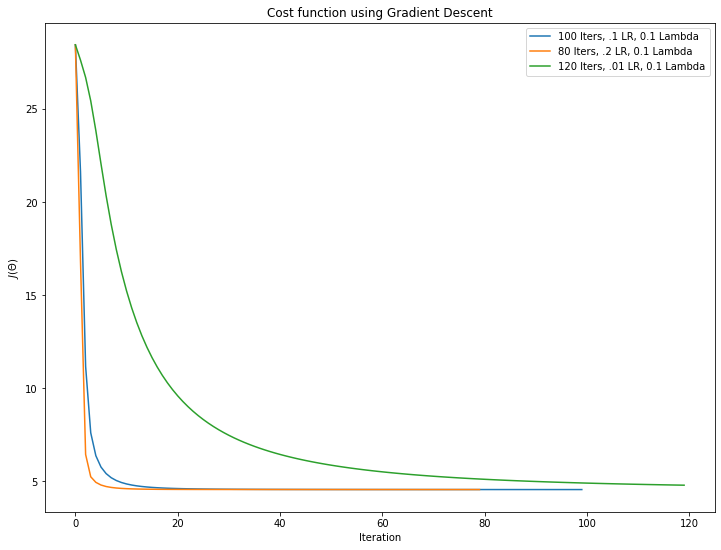

In [67]:
# Plot the cost function evolution during training.
#In order to say learning has finished, the cost function has to converge to a flat rate
plt.plot(nnJ_history1)  #
plt.plot(nnJ_history2)  #
plt.plot(nnJ_history3)  #

plt.legend(["100 Iters, .1 LR, 0.1 Lambda",
            "80 Iters, .2 LR, 0.1 Lambda",
            "120 Iters, .01 LR, 0.1 Lambda"])

plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

## Convolutional Neural Networks using Keras
For a first CNN model, let's use the used NN architecture implemented in the last paper

In [61]:
# Shaping our input array to be compatible with Keras
keras_train_examples = train_examples.reshape(246, 112, 92, 1)

In [68]:
model = models.Sequential()
    
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(112, 92, 1)))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(41, activation='softmax'))

In [69]:
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [70]:
print(keras_train_examples.shape)
model.fit(keras_train_examples, train_labels, epochs=10, batch_size=10)

(246, 112, 92, 1)
Train on 246 samples
Epoch 1/10
246/246 [==============================] - 6s 25ms/sample - loss: 3.9194 - accuracy: 0.0163
Epoch 2/10
246/246 [==============================] - 5s 21ms/sample - loss: 3.7254 - accuracy: 0.0447
Epoch 3/10
246/246 [==============================] - 6s 23ms/sample - loss: 3.6901 - accuracy: 0.0407
Epoch 4/10
246/246 [==============================] - 7s 30ms/sample - loss: 3.6173 - accuracy: 0.0569
Epoch 5/10
246/246 [==============================] - 8s 33ms/sample - loss: 3.2037 - accuracy: 0.1951
Epoch 6/10
246/246 [==============================] - 7s 27ms/sample - loss: 2.3403 - accuracy: 0.3780
Epoch 7/10
246/246 [==============================] - 5s 21ms/sample - loss: 1.1561 - accuracy: 0.6870
Epoch 8/10
246/246 [==============================] - 5s 21ms/sample - loss: 0.5113 - accuracy: 0.8415
Epoch 9/10
246/246 [==============================] - 5s 20ms/sample - loss: 0.2051 - accuracy: 0.9268
Epoch 10/10
246/246 [=============

In [71]:
valid_keras = X_valid[:,:-1].reshape(82, 112, 92, 1)

valid_loss, valid_acc = model.evaluate(valid_keras, X_valid[:, -1], verbose=2)

82/1 - 0s - loss: 0.9636 - accuracy: 0.9024


# Fine-tuning the best-performing model